<a href="https://colab.research.google.com/github/jprivera98/Hoja-de-trabajo-3/blob/main/Proyecto_Final_Text_Mining_%26_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Problema No.1

print("Montando Google Drive...")
from google.colab import drive
drive.mount('/content/drive')

# --- Librerías base
import os
import re
import gc
import sys
import csv
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# --- Visualización
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Preparación de Herramientas de NLP


import nltk
print("Descargando recursos de NLTK (puede tardar)...")
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, PorterStemmer
from nltk.stem import WordNetLemmatizer

# --- Lemmatización ES con spaCy (intento y fallback)
def cargar_spacy_es():
    """
    Intento cargar spaCy ES para lematizar en español.
    Si no está, intento instalar automáticamente.
    Si falla, regreso None y haré fallback al stemming/heurística.
    """
    try:
        import spacy
        try:
            nlp = spacy.load("es_core_news_sm")
        except Exception:
            import subprocess
            subprocess.run([sys.executable, "-m", "pip", "install", "-q", "spacy", "es_core_news_sm"])
            import spacy as _sp
            _sp.cli.download("es_core_news_sm")
            nlp = _sp.load("es_core_news_sm")
        return nlp
    except Exception as e:
        print(f"No pude cargar spaCy ES. Usaré stemming/Lemmatizer EN como fallback. Detalle: {e}")
        return None

nlp_es = cargar_spacy_es()

Descargando recursos de NLTK (puede tardar)...
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
#Carga Robusta de Datos

# 1) Carga de datos

csv_path = '/content/drive/MyDrive/Archivos proyecto final colab /tw_source.csv'

def cargar_datos_csv(ruta_csv: str) -> pd.DataFrame:
    """
    Carga robusta de CSV con múltiples estrategias:
    1) Intenta encodings comunes (utf-8, utf-8-sig, latin1, cp1252, iso-8859-1, utf-16).
    2) Si falla, usa engine='python' + sep=None (auto-sniff) + encoding_errors='replace'.
    3) Si falla encoding_errors, hago fallback leyendo binario y decodificando con 'replace'.
    """
    print("INICIANDO CARGA Y ANÁLISIS DE DATOS")
    print(f"Verificando archivo en: {ruta_csv}")

    if not os.path.exists(ruta_csv):
        print("El archivo no existe.")
        return pd.DataFrame()

    tam_mb = os.path.getsize(ruta_csv) / (1024**2)
    print(f"Tamaño de archivo: {tam_mb:.2f} MB")

    encodings_por_intentar = [
        "utf-8",
        "utf-8-sig",
        "latin1",
        "cp1252",
        "iso-8859-1",
        "utf-16"
    ]

    # 1) Intento directo con varios encodings (engine='c')
    for enc in encodings_por_intentar:
        try:
            print(f"Probando encoding: {enc} (engine='c')")
            df = pd.read_csv(
                ruta_csv,
                encoding=enc,
                low_memory=False
            )
            print(f"Cargado con encoding {enc}: {df.shape[0]:,} x {df.shape[1]}")
            print(f"   Memoria: {df.memory_usage(deep=True).sum()/1024**2:.2f} MB")
            return df
        except UnicodeDecodeError as e:
            print(f"   UnicodeDecodeError con {enc}: {e}")
        except Exception as e:
            print(f"   Error con {enc}: {e}")

    # 2) Fallback tolerante: engine='python' + sep=None (auto), reemplazo de caracteres inválidos
    try:
        print("Fallback tolerante (engine='python', sep=None, encoding='latin1', encoding_errors='replace')")
        df = pd.read_csv(
            ruta_csv,
            engine='python',
            sep=None,               # autodetección de delimitador
            encoding='latin1',
            encoding_errors='replace',  # pandas >= 1.4
            quoting=csv.QUOTE_MINIMAL,
            low_memory=False,
            on_bad_lines='skip'     # salta líneas irregulares
        )
        print(f"Cargado con fallback tolerante: {df.shape[0]:,} x {df.shape[1]}")
        print(f"   Memoria: {df.memory_usage(deep=True).sum()/1024**2:.2f} MB")
        return df
    except TypeError:
        # Por si la versión de pandas no soporta encoding_errors
        try:
            print("Fallback alterno (sin encoding_errors): leo binario y decodifico reemplazando")
            with open(ruta_csv, 'rb') as f:
                data = f.read().decode('latin1', errors='replace')
            from io import StringIO
            df = pd.read_csv(
                StringIO(data),
                engine='python',
                sep=None,
                quoting=csv.QUOTE_MINIMAL,
                low_memory=False,
                on_bad_lines='skip'
            )
            print(f"Cargado con fallback alterno: {df.shape[0]:,} x {df.shape[1]}")
            print(f"   Memoria: {df.memory_usage(deep=True).sum()/1024**2:.2f} MB")
            return df
        except Exception as e2:
            print(f"Error en fallback alterno: {e2}")
            return pd.DataFrame()
    except Exception as e:
        print(f"No se pudo cargar el CSV con ningún método. Detalle: {e}")
        return pd.DataFrame()

df = cargar_datos_csv(csv_path)
if df.empty:
    raise SystemExit("No se pudo cargar el dataset. Verifica el path y vuelve a ejecutar.")

INICIANDO CARGA Y ANÁLISIS DE DATOS
Verificando archivo en: /content/drive/MyDrive/Archivos proyecto final colab /tw_source.csv
Tamaño de archivo: 227.74 MB
Probando encoding: utf-8 (engine='c')
   UnicodeDecodeError con utf-8: 'utf-8' codec can't decode bytes in position 80-81: invalid continuation byte
Probando encoding: utf-8-sig (engine='c')
   UnicodeDecodeError con utf-8-sig: 'utf-8' codec can't decode bytes in position 232719-232720: invalid continuation byte
Probando encoding: latin1 (engine='c')
Cargado con encoding latin1: 1,599,999 x 6
   Memoria: 507.20 MB


In [4]:
#Detección de Columnas Clave

def detectar_columnas_usuario_y_texto(df: pd.DataFrame):
    """
    Identifico columnas candidatas de usuario y texto. Si no hay columna de usuario,
    podré medir popularidad por menciones @handle via regex.
    """
    cols = list(df.columns)

    # Heurísticas de usuario
    patrones_usuario = ['user', 'author', 'screen', 'username', 'handle', 'name']
    candidatos_usuario = [c for c in cols if any(p in c.lower() for p in patrones_usuario)]

    # Heurísticas de texto
    patrones_texto = ['text', 'content', 'tweet', 'message', 'body', 'status']
    candidatos_texto = [c for c in cols if any(p in c.lower() for p in patrones_texto)]

    # Si no encontré texto, pruebo por longitudes medias altas
    if not candidatos_texto:
        for c in cols:
            if df[c].dtype == 'object':
                muestra = df[c].dropna().astype(str).head(50)
                if not muestra.empty and muestra.str.len().mean() > 50:
                    candidatos_texto.append(c)

    col_usuario = candidatos_usuario[0] if candidatos_usuario else None
    col_texto   = candidatos_texto[0] if candidatos_texto   else None
    return col_usuario, col_texto

col_usuario, col_texto = detectar_columnas_usuario_y_texto(df)
print("\nColumnas detectadas:")
print(" - Usuario:", col_usuario)
print(" - Texto  :", col_texto)

if not col_texto:
    raise SystemExit("No pude detectar columna de texto. Revisa el CSV y ajusta las heurísticas si es necesario.")


Columnas detectadas:
 - Usuario: None
 - Texto  : @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


In [5]:
#Funciones de Limpieza y Procesamiento de Texto

# Stopwords ES/EN + extras de Twitter
stop_es = set(stopwords.words('spanish'))
stop_en = set(stopwords.words('english'))
stop_tw = {
    'rt','via','amp','http','https','www','com','co','twitter',
    'tweet','tweets','retweet','follow','like','please','thanks',
    'thank','you','me','my','i','we','our','us','he','she',
    'they','them','their','his','her','him'
}
STOP_ALL = stop_es | stop_en | stop_tw

stem_es = SnowballStemmer('spanish')
stem_en = PorterStemmer()
lemm_en = WordNetLemmatizer()

# Expresiones regulares que usaré repetidamente
URL_RE   = re.compile(r'https?://\S+')
MENT_RE  = re.compile(r'@([A-Za-z0-9_]{2,50})')
NONALPH  = re.compile(r'[^a-záéíóúüñA-ZÁÉÍÓÚÜÑ\s]')  # con tildes ES
MULTISPC = re.compile(r'\s+')

def limpiar_basico(texto: str) -> str:
    """
    En este paso hago limpieza "ligera" para conservar el contexto semántico:
    - Quito URLs y normalizo espacios.
    - Mantengo palabras con acentos. Elimino signos raros.
    - Bajo a minúsculas.
    """
    if pd.isna(texto): return ""
    t = str(texto)
    t = URL_RE.sub(' ', t)
    t = NONALPH.sub(' ', t)
    t = MULTISPC.sub(' ', t)
    return t.strip().lower()

def tokens_procesados(texto: str) -> list:
    """
    Tokenizo y aplico:
      - stopwords ES/EN,
      - stemming ES/EN,
      - lematización EN + ES (si spaCy está disponible).
    Devuelvo una lista de tokens "normalizados".
    """
    if not texto: return []
    try:
        toks = word_tokenize(texto)
    except:
        toks = texto.split()

    # Quito tokens no alfabéticos y stopwords
    toks = [t for t in toks if t.isalpha() and t not in STOP_ALL and len(t) >= 3]

    # Lematizo EN y ES cuando corresponda; mezclo estrategias:
    if nlp_es is not None:
        # spaCy para ES
        doc = nlp_es(" ".join(toks))
        norm = []
        for tok in doc:
            base = tok.lemma_.lower()
            if base and base not in STOP_ALL and base.isalpha() and len(base) >= 3:
                norm.append(base)
        return norm
    else:
        # Fallback ES: stemming + lemmatizer EN
        norm = []
        for t in toks:
            if re.search(r'[áéíóúüñ]', t.lower()):
                norm.append(stem_es.stem(t))
            else:
                lemma = lemm_en.lemmatize(t)
                lemma = lemma if lemma else t
                lemma = stem_en.stem(lemma)
                norm.append(lemma)
        return norm

def extraer_contexto_alrededor_usuario(texto: str, usuario: str, ventana_pal=5) -> list:
    """
    Extraigo CONTEXTO alrededor del nombre del usuario.
    Detecto @usuario o el nombre "pelado" (sin @) y me quedo con un
    vecindario en palabras (± ventana_pal).
    """
    if pd.isna(texto) or not str(texto).strip():
        return []

    # Trabajo con una versión limpia para tokenizar, pero manteniendo proximidad
    base = limpiar_basico(texto)
    if not base:
        return []

    usuario_pelado = str(usuario).replace('@', '')
    # Tokenizo sin perder orden
    try:
        toks = word_tokenize(base)
    except:
        toks = base.split()

    # Índices donde aparece el usuario (con o sin @)
    indices = []
    for i, tk in enumerate(toks):
        if tk == f"@{usuario_pelado}".lower() or tk == usuario_pelado.lower():
            indices.append(i)

    if not indices:
        return []

    # Construyo la ventana de contexto
    contexto = []
    for idx in indices:
        ini = max(0, idx - ventana_pal)
        fin = min(len(toks), idx + ventana_pal + 1)
        ventana = [t for j, t in enumerate(toks[ini:fin], start=ini) if j != idx]
        contexto.extend(ventana)

    # Normalizo (stopwords + stemming/lemma)
    contexto_limpio = tokens_procesados(" ".join(contexto))
    return contexto_limpio

In [6]:
#Identificación de los usuarios más populares

def top_usuarios(df: pd.DataFrame, col_usuario: str, col_texto: str, k:int=3):
    """
    Si tengo columna de usuario/autor, uso esa métrica (tweets por usuario).
    Si no, infiero popularidad por usuarios más mencionados (@handle) con regex.
    Devuelvo (lista_top, criterio_usado).
    """
    if col_usuario is not None:
        vc = df[col_usuario].astype(str).value_counts()
        top = list(vc.head(k).index)
        return top, "autor"
    else:
        # Conteo de menciones en todo el dataset (muestreo si es enorme)
        series_texto = df[col_texto].dropna().astype(str)
        if len(series_texto) > 300_000:
            series_texto = series_texto.sample(300_000, random_state=42)

        menciones = []
        for t in series_texto:
            menciones.extend(re.findall(r'@([A-Za-z0-9_]{2,50})', t))
        if not menciones:
            return [], "ninguno"

        s = pd.Series(menciones).str.lower().value_counts()
        top = ["@" + u for u in list(s.head(k).index)]
        return top, "mención"

top3, criterio = top_usuarios(df, col_usuario, col_texto, k=3)
print(f"\nCriterio usado para 'usuarios más populares': {criterio.upper()}")
print("Top 3 usuarios:", top3)

if not top3:
    raise SystemExit("No pude determinar usuarios más populares. Revisa el dataset.")


Criterio usado para 'usuarios más populares': MENCIÓN
Top 3 usuarios: ['@mileycyrus', '@tommcfly', '@ddlovato']


In [7]:
#Creación de Corpus por Usuario

corpus_por_usuario = {}
print("\nCreando corpus por usuario...")

for u in top3:
    # Selección de tweets "propios" del usuario (si tengo columna de autor)
    if col_usuario is not None and criterio == "autor":
        df_u = df[df[col_usuario].astype(str) == str(u)].copy()
    else:
        # Si el criterio fue mención, armo el corpus con los tweets que lo mencionan
        usuario_pelado = str(u).replace('@','')
        mask = df[col_texto].astype(str).str.contains(fr'@{re.escape(usuario_pelado)}\b', case=False, na=False)
        df_u = df[mask].copy()

    # METADATA requerida
    cand_id_cols = [c for c in df_u.columns if c.lower() in ("id","tweet_id","status_id","id_str")]
    if cand_id_cols:
        ID = df_u[cand_id_cols[0]].astype(str).tolist()
    else:
        ID = [f"gen_{i}" for i in range(1, len(df_u)+1)]

    cand_ts_cols = [c for c in df_u.columns if any(p in c.lower() for p in ("time","date","created","timestamp"))]
    if cand_ts_cols:
        TS = pd.to_datetime(df_u[cand_ts_cols[0]], errors='coerce')
        if TS.isna().mean() > 0.5:
            TS = pd.date_range("2023-01-01", periods=len(df_u), freq="min")
        TS = TS.astype(str).tolist()
    else:
        TS = pd.date_range("2023-01-01", periods=len(df_u), freq="min").astype(str).tolist()

    CONTENT = df_u[col_texto].astype(str).tolist()  # Tweet original
    LENGTH  = [len(t) for t in CONTENT]             # Longitud en caracteres

    corpus_por_usuario[u] = {
        "Content": CONTENT,
        "Metadata": {
            "ID": ID,
            "Timestamp": TS,
            "Length": LENGTH
        }
    }
    print(f" - {u}: corpus con {len(CONTENT)} tweets")


Creando corpus por usuario...
 - @mileycyrus: corpus con 4562 tweets
 - @tommcfly: corpus con 3898 tweets
 - @ddlovato: corpus con 3460 tweets



Extrayendo contexto alrededor de cada usuario y generando WordClouds...

Top-10 palabras de contexto para @mileycyrus:
   miley: 591
   love: 240
   quot: 179
   hey: 177
   good: 172
   hope: 146
   vote: 120
   voted: 105
   luck: 103
   come: 101

Top-10 palabras de contexto para @tommcfly:
   tom: 562
   say: 170
   hey: 154
   good: 139
   dannymcfly: 94
   haha: 93
   love: 87
   dougiemcfly: 85
   guys: 82
   quot: 80

Top-10 palabras de contexto para @ddlovato:
   demi: 422
   love: 193
   wish: 156
   hey: 120
   hope: 99
   wait: 89
   selenagomez: 88
   awesome: 88
   could: 87
   good: 83


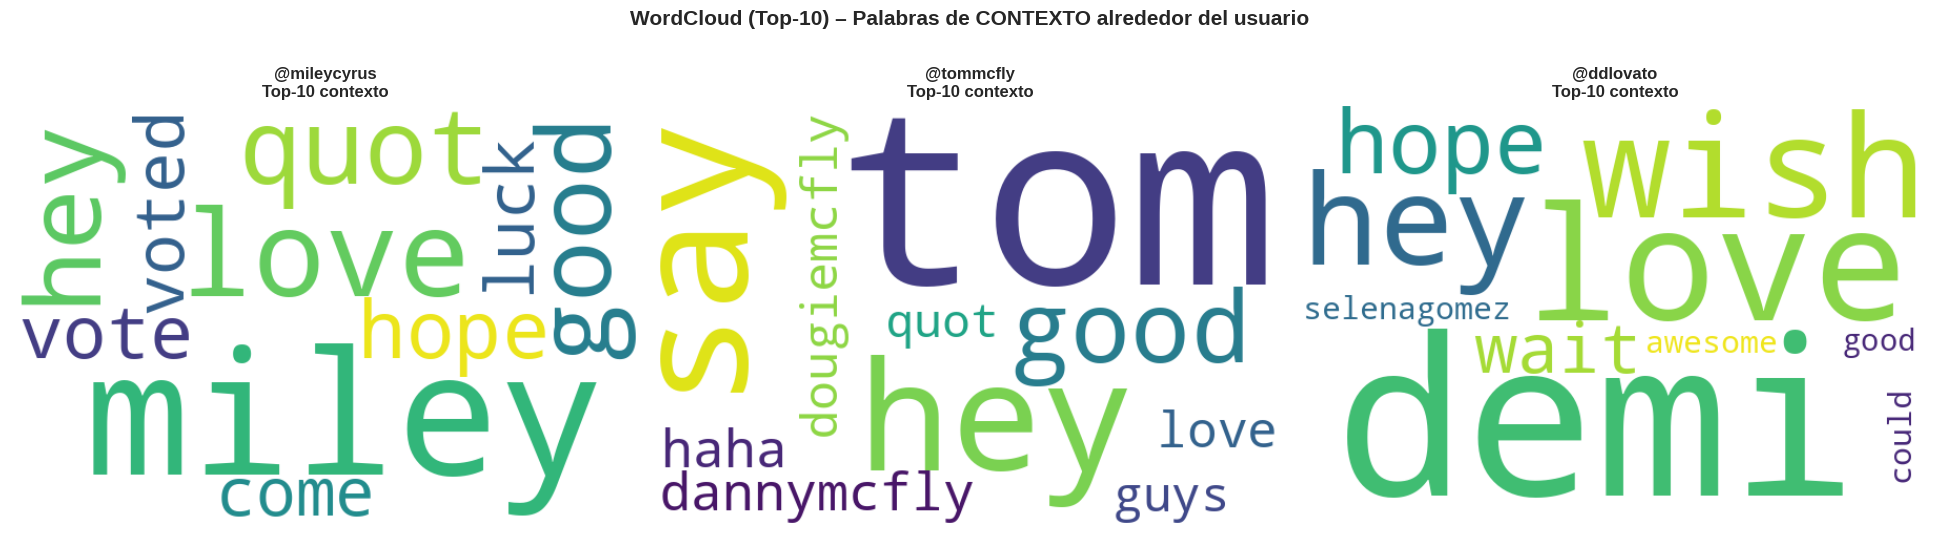

In [8]:
#Extracción de Contexto y Generación de WordClouds

from collections import Counter

print("\nExtrayendo contexto alrededor de cada usuario y generando WordClouds...")

# Creo carpeta de salida en tu misma ruta (para guardar PNGs)
out_dir = '/content/drive/MyDrive/Archivos proyecto final colab /outputs'
os.makedirs(out_dir, exist_ok=True)

fig, axes = plt.subplots(1, len(top3), figsize=(6.5*len(top3), 6))
fig.suptitle('WordCloud (Top-10) – Palabras de CONTEXTO alrededor del usuario', fontsize=15, fontweight='bold')

if len(top3) == 1:
    axes = [axes]  # homogeneizo iteración

for i, u in enumerate(top3):
    usuario_pelado = str(u).replace('@', '')
    mask_mentions = df[col_texto].astype(str).str.contains(fr'@{re.escape(usuario_pelado)}\b', case=False, na=False) | \
                    df[col_texto].astype(str).str.contains(fr'\b{re.escape(usuario_pelado)}\b', case=False, na=False)
    df_ctx = df[mask_mentions].copy()

    # Si hay demasiados, limito para acelerar
    if len(df_ctx) > 50_000:
        df_ctx = df_ctx.sample(50_000, random_state=42)

    # Junto todo el contexto normalizado
    contexto_tokens = []
    for t in df_ctx[col_texto].astype(str):
        contexto_tokens.extend(extraer_contexto_alrededor_usuario(t, u, ventana_pal=5))

    freqs = Counter(contexto_tokens).most_common(10)
    freqs_dict = dict(freqs)

    # >>> SUGERENCIA MINI (incluida): trazo textual del Top-10 por usuario
    if freqs_dict:
        print(f"\nTop-10 palabras de contexto para {u}:")
        for w, f in freqs:
            print(f"   {w}: {f}")

    if len(freqs_dict) == 0:
        axes[i].text(0.5, 0.5, 'Sin contexto suficiente', ha='center', va='center', fontsize=12, transform=axes[i].transAxes)
        axes[i].axis('off')
        axes[i].set_title(str(u), fontweight='bold')
        continue

    wc = WordCloud(
        width=600, height=400,
        background_color='white',
        colormap='viridis',
        max_words=10,
        relative_scaling=0.5,
        collocations=False
    ).generate_from_frequencies(freqs_dict)

    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"{u}\nTop-10 contexto", fontweight='bold')
    # Guardo PNG
    wc.to_file(os.path.join(out_dir, f'wordcloud_contexto_{str(u).replace("@","")}.png'))

plt.tight_layout()
plt.show()

In [9]:
#Resumen Final

print("\nRESUMEN FINAL")
print(f"Dataset procesado: {len(df):,} registros")
print(f"Criterio popularidad: {criterio.upper()}")
for u in top3:
    total_tweets = len(corpus_por_usuario[u]["Content"])
    long_prom = np.mean(corpus_por_usuario[u]["Metadata"]["Length"]) if total_tweets else 0
    print(f"  {u}: {total_tweets} tweets en corpus | Length promedio: {long_prom:.1f} chars")

print(f"\nWordClouds guardados (PNG) en: {out_dir}")
print("Contenido del corpus cumple: Content=Tweet original; Metadata={ID, Timestamp, Length}")
print("Contexto extraído con regex, stopwords, stemming y lematización (ES/EN).")


RESUMEN FINAL
Dataset procesado: 1,599,999 registros
Criterio popularidad: MENCIÓN
  @mileycyrus: 4562 tweets en corpus | Length promedio: 85.2 chars
  @tommcfly: 3898 tweets en corpus | Length promedio: 86.6 chars
  @ddlovato: 3460 tweets en corpus | Length promedio: 87.6 chars

WordClouds guardados (PNG) en: /content/drive/MyDrive/Archivos proyecto final colab /outputs
Contenido del corpus cumple: Content=Tweet original; Metadata={ID, Timestamp, Length}
Contexto extraído con regex, stopwords, stemming y lematización (ES/EN).


EJERCICIO NO.2

In [ ]:
#Fase 1: Configuración Inicial y Localización del Dataset

In [10]:
print("Montando Google Drive...")
from google.colab import drive
drive.mount('/content/drive')

# Dependencias e importaciones que utilizaré.
import os, sys, shutil, random, json, re
from glob import glob
from pathlib import Path
from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from sklearn.metrics import classification_report, confusion_matrix

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)

# Localización del dataset (respeto el path solicitado).
# Respeto EXACTAMENTE el path que me indicaron (con espacios y paréntesis):
base_dir = Path('/content/drive/MyDrive/Archivos proyecto final colab /Ejercicio no.2 /Fruits_Vegetables_Dataset(12000)')
assert base_dir.exists(), f"No existe la carpeta: {base_dir}"
print("Directorio base:", base_dir)
print("Contenido de primer nivel:", [p.name for p in base_dir.iterdir() if p.is_dir()][:20])

Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow: 2.19.0
Directorio base: /content/drive/MyDrive/Archivos proyecto final colab /Ejercicio no.2 /Fruits_Vegetables_Dataset(12000)
Contenido de primer nivel: ['Vegetables', 'Fruits']


In [11]:
# Fase 2: Detección y Selección de Clases

# Recorro todo el árbol de directorios para detectar las carpetas "hoja" que contienen las imágenes.
# Luego, las clasifico usando palabras clave en español e inglés. Esto me hace independiente de la estructura exacta de carpetas.

def is_image_file(p: Path):
    return p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def leaf_class_dirs(root: Path):
    """
    Devuelvo las carpetas 'hoja' que contienen imágenes (y cuyas subcarpetas no contienen más imágenes),
    lo que normalmente equivale a una clase.
    """
    leaves = []
    for d in root.rglob("*"):
        if d.is_dir():
            imgs_here = list(chain.from_iterable(d.glob(ext) for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")))
            if imgs_here:
                # si hay subcarpetas con imágenes, no es hoja
                sub_imgs = []
                for sd in d.iterdir():
                    if sd.is_dir():
                        sub_imgs.extend(list(chain.from_iterable(sd.glob(ext) for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp"))))
                if not sub_imgs:
                    leaves.append(d)
    return leaves

FRUIT_KW = {
    "apple","manzana","banana","plátano","platano","orange","naranja","grape","uva","pineapple","piña","pina",
    "mango","peach","durazno","pear","pera","cherry","cereza","watermelon","sandia","sandía","melon","melón",
    "kiwi","strawberry","fresa","blueberry","arándano","arandano","raspberry","frambuesa","blackberry","mora",
    "papaya","guava","guayaba","tangerine","mandarin","mandarina","pomegranate","granada","fig","higo","coconut","coco",
    "apricot","albaricoque","plum","ciruela","date","dátil","datil","dragonfruit","pitahaya","passionfruit","maracuyá","maracuya",
    "lime","lima","lemon","limón","limon","avocado","aguacate","lychee","litchi","starfruit","carambola","cranberry","pomelo","grapefruit"
}
VEG_KW = {
    "carrot","zanahoria","tomato","tomate","potato","papa","patata","onion","cebolla","pepper","pimiento","bellpepper",
    "cucumber","pepino","broccoli","brócoli","brocoli","cabbage","repollo","lettuce","lechuga","spinach","espinaca",
    "eggplant","berenjena","zucchini","calabacín","calabacin","cauliflower","coliflor","garlic","ajo","ginger","jengibre",
    "radish","rábano","rabano","beet","betabel","remolacha","pumpkin","calabaza","okra","quimbombó","quimbombo",
    "yam","ñame","name","celery","apio","asparagus","espárrago","esparrago","artichoke","alcachofa",
    "kale","arugula","rúcula","rucula","chard","acelga","turnip","nabo","peas","guisantes","beans","frijoles","habas",
    "chili","chile","jalapeño","jalapeno","serrano","habanero","mushroom","hongo","seta"
}

def normalize_name(s: str):
    s = s.lower()
    s = s.replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u").replace("ñ","n")
    return s

def classify_by_keywords(name: str):
    n = normalize_name(name)
    tokens = re.split(r"[^a-z]+", n)
    toks = set(t for t in tokens if t)
    if any(k in toks or k in n for k in FRUIT_KW):
        return "fruit"
    if any(k in toks or k in n for k in VEG_KW):
        return "veg"
    return None

leaf_dirs = leaf_class_dirs(base_dir)
print(f"Carpetas-hoja con imágenes: {len(leaf_dirs)} (ejemplos): {[p.name for p in leaf_dirs[:12]]}")

fruit_dirs, veg_dirs, unmapped = [], [], []
for d in leaf_dirs:
    kind = classify_by_keywords(d.name)
    if kind == "fruit":
        fruit_dirs.append(d)
    elif kind == "veg":
        veg_dirs.append(d)
    else:
        unmapped.append(d)

# Como fallback, si no llego a 3+3 clases, intento buscar directorios raíz que contengan 'fruit'/'veget' en cualquier nivel.
def find_category_roots(root: Path):
    f_roots, v_roots = [], []
    for d in root.rglob("*"):
        if d.is_dir():
            n = d.name.lower()
            if "fruit" in n:
                f_roots.append(d)
            if "veget" in n or "vege" in n:
                v_roots.append(d)
    return f_roots, v_roots

if len(fruit_dirs) < 3 or len(veg_dirs) < 3:
    f_roots, v_roots = find_category_roots(base_dir)
    if f_roots:
        cand = [c for c in f_roots[0].iterdir() if c.is_dir()]
        cand = [c for c in cand if list(c.rglob("*.jpg")) or list(c.rglob("*.png")) or list(c.rglob("*.jpeg"))]
        for c in cand:
            imgs_here = list(chain.from_iterable(c.glob(ext) for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")))
            if imgs_here:
                fruit_dirs.append(c)
            else:
                fruit_dirs.extend([x for x in leaf_class_dirs(c) if x not in fruit_dirs])
    if v_roots:
        cand = [c for c in v_roots[0].iterdir() if c.is_dir()]
        cand = [c for c in cand if list(c.rglob("*.jpg")) or list(c.rglob("*.png")) or list(c.rglob("*.jpeg"))]
        for c in cand:
            imgs_here = list(chain.from_iterable(c.glob(ext) for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")))
            if imgs_here:
                veg_dirs.append(c)
            else:
                veg_dirs.extend([x for x in leaf_class_dirs(c) if x not in veg_dirs])

# Deduplico y reporto los resultados.
fruit_dirs = sorted(set(fruit_dirs), key=lambda p: p.as_posix())
veg_dirs   = sorted(set(veg_dirs),   key=lambda p: p.as_posix())

print("\nResumen de clasificación:")
print(" - Frutas detectadas:", len(fruit_dirs), [p.name for p in fruit_dirs[:10]])
print(" - Vegetales detectados:", len(veg_dirs), [p.name for p in veg_dirs[:10]])
print(" - No mapeadas:", len(unmapped))

if len(fruit_dirs) < 3 or len(veg_dirs) < 3:
    # Diagnóstico de la estructura de carpetas.
    print("\nDiagnóstico rápido (primer nivel):")
    for p in sorted([x for x in base_dir.iterdir() if x.is_dir()])[:20]:
        print("  -", p.name, "→ subdirs:", [sd.name for sd in list(p.iterdir())[:8] if sd.is_dir()])
    raise ValueError("No pude detectar ≥3 clases de frutas y ≥3 de vegetales. "
                     "Revisa nombres de carpetas o amplía keywords.")

# Selecciono 3 clases de frutas y 3 de vegetales de forma determinística (orden alfabético).
selected_fruits = [d.name for d in fruit_dirs][:3]
selected_vegs   = [d.name for d in veg_dirs][:3]
selected_classes = selected_fruits + selected_vegs

print("\nSelección final de clases:")
print(" - Frutas (3):", selected_fruits)
print(" - Vegetales (3):", selected_vegs)

Carpetas-hoja con imágenes: 20 (ejemplos): ['RottenCucumber', 'FreshTomato', 'RottenBellpepper', 'FreshCarrot', 'FreshBellpepper', 'RottenCarrot', 'RottenTomato', 'FreshPotato', 'FreshCucumber', 'RottenPotato', 'FreshBanana', 'RottenMango']

Resumen de clasificación:
 - Frutas detectadas: 10 ['FreshApple', 'FreshBanana', 'FreshMango', 'FreshOrange', 'FreshStrawberry', 'RottenApple', 'RottenBanana', 'RottenMango', 'RottenOrange', 'RottenStrawberry']
 - Vegetales detectados: 10 ['FreshBellpepper', 'FreshCarrot', 'FreshCucumber', 'FreshPotato', 'FreshTomato', 'RottenBellpepper', 'RottenCarrot', 'RottenCucumber', 'RottenPotato', 'RottenTomato']
 - No mapeadas: 0

Selección final de clases:
 - Frutas (3): ['FreshApple', 'FreshBanana', 'FreshMango']
 - Vegetales (3): ['FreshBellpepper', 'FreshCarrot', 'FreshCucumber']


In [12]:
#Fase 3: Creación de los Conjuntos de Datos (Train/Validation/Test)

subset_root = Path("/content/fv_subset")
if subset_root.exists():
    shutil.rmtree(subset_root)
for split in ["train", "val", "test"]:
    (subset_root / split).mkdir(parents=True, exist_ok=True)

def recolectar_imagenes_de_clase(class_dir: Path):
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
    files = list(chain.from_iterable(class_dir.glob(e) for e in exts))
    return files

def copiar_split(files, dst_dir: Path, class_name: str, max_per_class=None):
    dst = dst_dir / class_name
    dst.mkdir(parents=True, exist_ok=True
              )
    if max_per_class:
        files = files[:max_per_class]
    for f in files:
        shutil.copy2(f, dst / f.name)

def crear_splits_para_clase(class_dir: Path, split_ratio=(0.7,0.15,0.15), max_per_class=None):
    files = recolectar_imagenes_de_clase(class_dir)
    random.shuffle(files)
    n = len(files)
    assert n > 0, f"No hay imágenes en {class_dir}"
    n_train = int(n * split_ratio[0])
    n_val   = int(n * split_ratio[1])
    train_files = files[:n_train]
    val_files   = files[n_train:n_train+n_val]
    test_files  = files[n_train+n_val:]
    return train_files, val_files, test_files

# Creo un mapa de nombre de clase a su ruta para facilitar la copia.
name2path = {d.name: d for d in (fruit_dirs + veg_dirs)}

# Copio los archivos para las 6 clases seleccionadas.
for cname in selected_classes:
    cdir = name2path[cname]
    train_files, val_files, test_files = crear_splits_para_clase(cdir, split_ratio=(0.7,0.15,0.15))
    copiar_split(train_files, subset_root / "train", cname)
    copiar_split(val_files,   subset_root / "val",   cname)
    copiar_split(test_files,  subset_root / "test",  cname)

print("\nEstructura lista en:", subset_root)
print("Clases en train:", os.listdir(subset_root / "train"))


Estructura lista en: /content/fv_subset
Clases en train: ['FreshCarrot', 'FreshCucumber', 'FreshBanana', 'FreshMango', 'FreshBellpepper', 'FreshApple']


In [13]:
#Fase 4: Aumento de Datos y Preprocesamiento de imagenes

# Trabajo en COLOR (3 canales) para aprovechar los modelos pre-entrenados como MobileNetV2.
IMG_SIZE = (224, 224)
IMG_CHANNELS = 3
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=0.12,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

color_mode = "rgb" if IMG_CHANNELS == 3 else "grayscale"

train_flow = train_gen.flow_from_directory(
    directory=str(subset_root / "train"),
    target_size=IMG_SIZE,
    color_mode=color_mode,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)
val_flow = val_gen.flow_from_directory(
    directory=str(subset_root / "val"),
    target_size=IMG_SIZE,
    color_mode=color_mode,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
test_flow = test_gen.flow_from_directory(
    directory=str(subset_root / "test"),
    target_size=IMG_SIZE,
    color_mode=color_mode,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_flow.num_classes
class_indices = train_flow.class_indices
idx_to_class = {v:k for k,v in class_indices.items()}
print("Clases e índices:", class_indices)



Found 2566 images belonging to 6 classes.
Found 546 images belonging to 6 classes.
Found 556 images belonging to 6 classes.
Clases e índices: {'FreshApple': 0, 'FreshBanana': 1, 'FreshBellpepper': 2, 'FreshCarrot': 3, 'FreshCucumber': 4, 'FreshMango': 5}


In [14]:
#Fase 5: Definición de Arquitecturas de Modelos y Callbacks

# Preparo los callbacks (early stopping + checkpoint).
ckpt_dir = Path("/content/checkpoints")
ckpt_dir.mkdir(exist_ok=True)
def get_callbacks(name):
    return [
        callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
        callbacks.ModelCheckpoint(filepath=str(ckpt_dir / f"best_{name}.keras"),
                                  monitor="val_accuracy", save_best_only=True)
    ]

# Defino 3 arquitecturas CNN.
def build_cnn_baseline(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer=optimizers.Adam(1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

def build_cnn_deeper(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

def build_cnn_transfer_mobilenet(input_shape, num_classes):
    def mobilenet_preproc_layer(x):
        # mis imágenes entran en el rango 0..1; MobileNetV2 espera [-1, 1] tras su preprocesamiento,
        # por eso aplico su preprocesador a x*255.0
        return mobilenet_preprocess(x*255.0)

    inputs = layers.Input(shape=input_shape)
    x = layers.Lambda(mobilenet_preproc_layer)(inputs)

    base = MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")
    base.trainable = False
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

input_shape = (IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS)


Entrenando: baseline
Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - accuracy: 0.3372 - loss: 4.1875 - val_accuracy: 0.6685 - val_loss: 0.9206
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - accuracy: 0.6777 - loss: 0.8619 - val_accuracy: 0.7949 - val_loss: 0.5629
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.7712 - loss: 0.6578 - val_accuracy: 0.8132 - val_loss: 0.5468
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 375s 4s/step - accuracy: 0.8009 - loss: 0.5533 - val_accuracy: 0.8480 - val_loss: 0.4402
Epoch 5/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 0.8019 - loss: 0.5400 - val_accuracy: 0.8663 - val_loss: 0.3483
Epoch 6/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.8334 - loss: 0.4596 - val_accuracy: 0.8828 - val_loss: 0.2946
Epoch 7/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 0.8406 - loss: 0.4259 - val_accuracy: 0.9029 - val_loss: 0.2654
Epoch 8/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - accuracy: 0.8571 - loss: 0.3673 - va

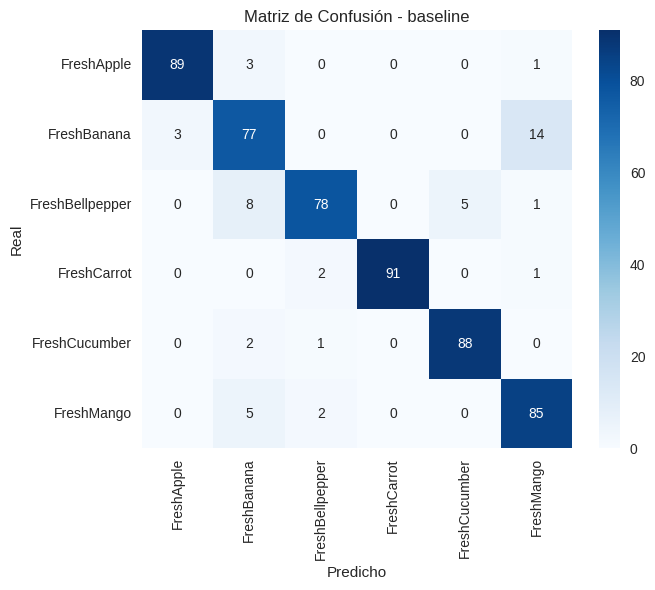


Entrenando: deeper_bn
Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 1404s 17s/step - accuracy: 0.5156 - loss: 1.2846 - val_accuracy: 0.1685 - val_loss: 2.9958
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 1384s 17s/step - accuracy: 0.7169 - loss: 0.7334 - val_accuracy: 0.1630 - val_loss: 4.6962
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 1377s 17s/step - accuracy: 0.7811 - loss: 0.5785 - val_accuracy: 0.1703 - val_loss: 4.6939
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 1357s 17s/step - accuracy: 0.8039 - loss: 0.5439 - val_accuracy: 0.1868 - val_loss: 4.0613
Epoch 5/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 1401s 17s/step - accuracy: 0.8319 - loss: 0.4246 - val_accuracy: 0.2161 - val_loss: 3.3785
Epoch 6/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 1407s 17s/step - accuracy: 0.8596 - loss: 0.4009 - val_accuracy: 0.4762 - val_loss: 1.4714
Epoch 7/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 1377s 17s/step - accuracy: 0.8655 - loss: 0.3624 - val_accuracy: 0.6960 - val_loss: 0.7717
Epoch 8/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 1354s 17s/step - accuracy: 0.8832 - 

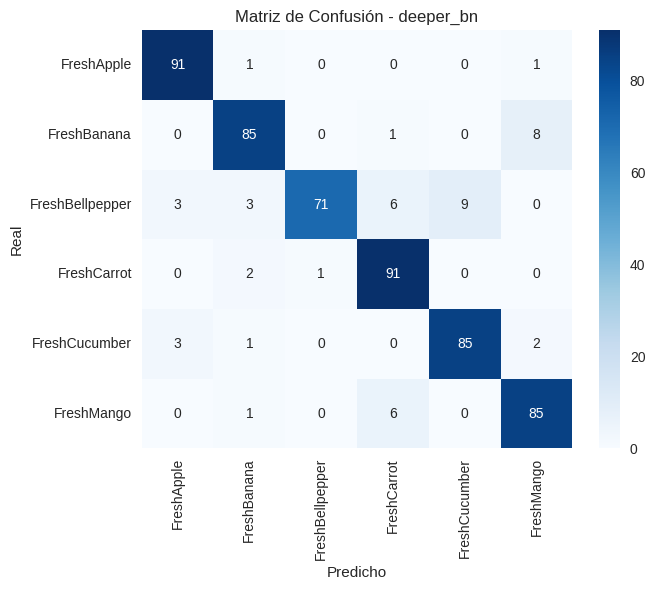

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Entrenando: mobilenetv2
Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.5623 - loss: 1.2087 - val_accuracy: 0.9799 - val_loss: 0.1016
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.9774 - loss: 0.1148 - val_accuracy: 0.9853 - val_loss: 0.0603
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9845 - loss: 0.0660 - val_accuracy: 0.9945 - val_loss: 0.0415
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9899 - loss: 0.0469 - val_accuracy: 0.9945 - val_loss: 0.0341
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.9908 - loss: 0.0382 - val_accuracy: 0.9927 - val_loss: 0.0309
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9923 - loss: 0.0313 - val_accuracy: 0.9927 - val_loss: 0.0276
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9930 - loss: 0.0293 - val_accuracy: 0.9927 - val_loss: 0.0290
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━

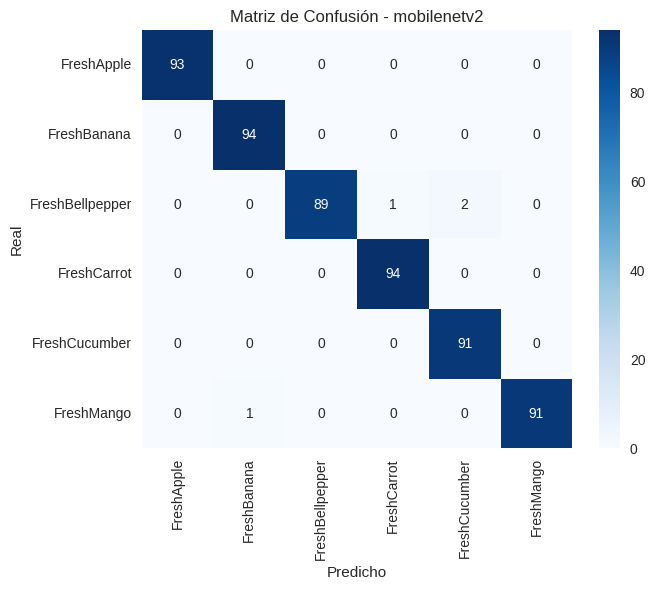


Fine-tuning (descongelando últimas capas de MobileNetV2)

Entrenando: mobilenetv2_ft
Epoch 1/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 307s 4s/step - accuracy: 0.9537 - loss: 0.1370 - val_accuracy: 0.9890 - val_loss: 0.0393
Epoch 2/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.9910 - loss: 0.0252 - val_accuracy: 0.9945 - val_loss: 0.0156
Epoch 3/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 329s 4s/step - accuracy: 0.9970 - loss: 0.0097 - val_accuracy: 0.9963 - val_loss: 0.0113
Epoch 4/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.9972 - loss: 0.0133 - val_accuracy: 0.9945 - val_loss: 0.0102
Epoch 5/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 285s 4s/step - accuracy: 0.9946 - loss: 0.0148 - val_accuracy: 0.9982 - val_loss: 0.0068
Epoch 6/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.9980 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 0.0036
Evaluando mobilenetv2_ft en TEST...

Classification Report - mobilenetv2_ft
                 precision    recall  f1-score   support

     FreshApple     1.00

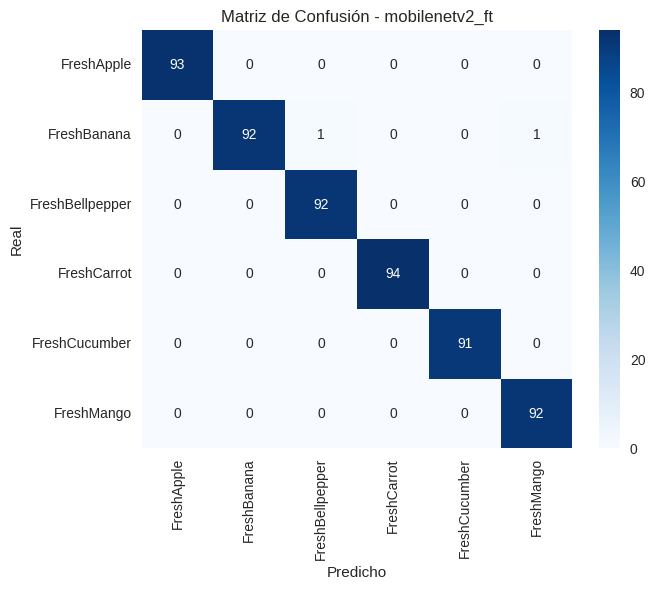

In [15]:
#Fase 6: Entrenamiento y Evaluación de los Modelos

histories = {}
test_metrics = {}

def entrenar_y_evaluar(model, name, epochs=20):
    print(f"\nEntrenando: {name}")
    cb = get_callbacks(name)
    hist = model.fit(
        train_flow,
        validation_data=val_flow,
        epochs=epochs,
        callbacks=cb,
        verbose=1
    )
    histories[name] = hist

    print(f"Evaluando {name} en TEST...")
    test_loss, test_acc = model.evaluate(test_flow, verbose=0)
    test_metrics[name] = {"loss": float(test_loss), "accuracy": float(test_acc)}

    # Genero predicciones para el reporte.
    y_true = test_flow.classes
    y_prob = model.predict(test_flow, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    print(f"\nClassification Report - {name}")
    print(classification_report(y_true, y_pred,
                                target_names=[idx_to_class[i] for i in range(NUM_CLASSES)],
                                digits=4))

    # Creo la matriz de confusión.
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[idx_to_class[i] for i in range(NUM_CLASSES)],
                yticklabels=[idx_to_class[i] for i in range(NUM_CLASSES)])
    plt.title(f"Matriz de Confusión - {name}")
    plt.xlabel("Predicho"); plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

# Modelo 1: Baseline
model_baseline = build_cnn_baseline(input_shape, NUM_CLASSES)
entrenar_y_evaluar(model_baseline, "baseline", epochs=15)

# Modelo 2: Deeper + BN/Dropout
model_deeper = build_cnn_deeper(input_shape, NUM_CLASSES)
entrenar_y_evaluar(model_deeper, "deeper_bn", epochs=15)

# Modelo 3: Transfer Learning MobileNetV2
model_tl = build_cnn_transfer_mobilenet(input_shape, NUM_CLASSES)
entrenar_y_evaluar(model_tl, "mobilenetv2", epochs=10)

# Realizo un fine-tuning ligero de MobileNetV2
print("\nFine-tuning (descongelando últimas capas de MobileNetV2)")
for layer in model_tl.layers:
    if "mobilenetv2" in layer.name:
        # descongelo aproximadamente el último tercio del modelo base.
        for i, l in enumerate(layer.layers):
            l.trainable = (i > int(2*len(layer.layers)/3))
        break
model_tl.compile(optimizer=optimizers.Adam(1e-4),
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])
entrenar_y_evaluar(model_tl, "mobilenetv2_ft", epochs=6)

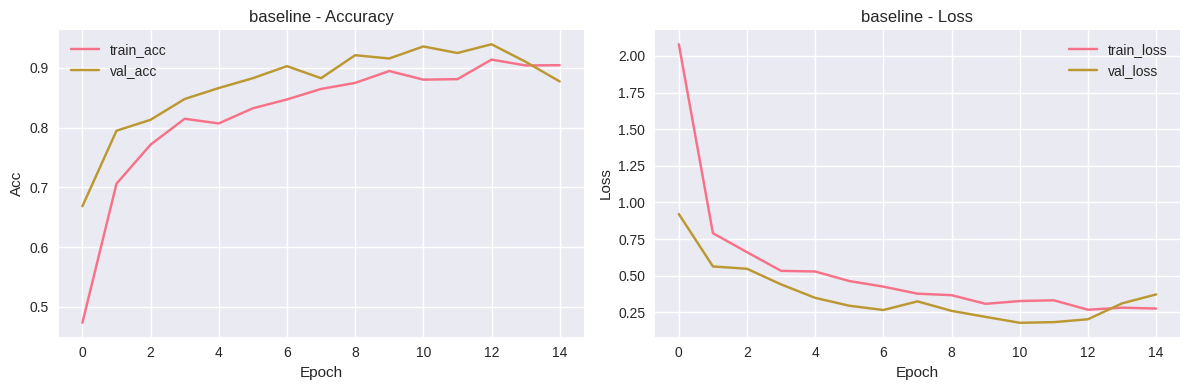

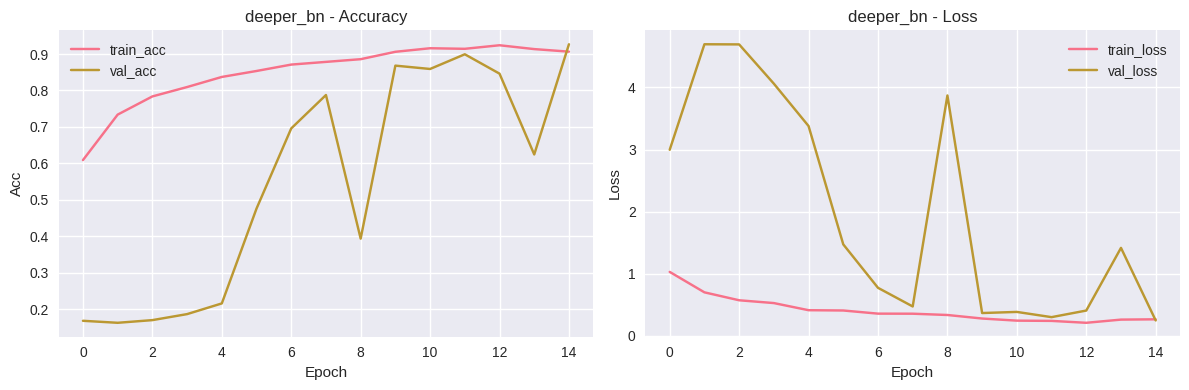

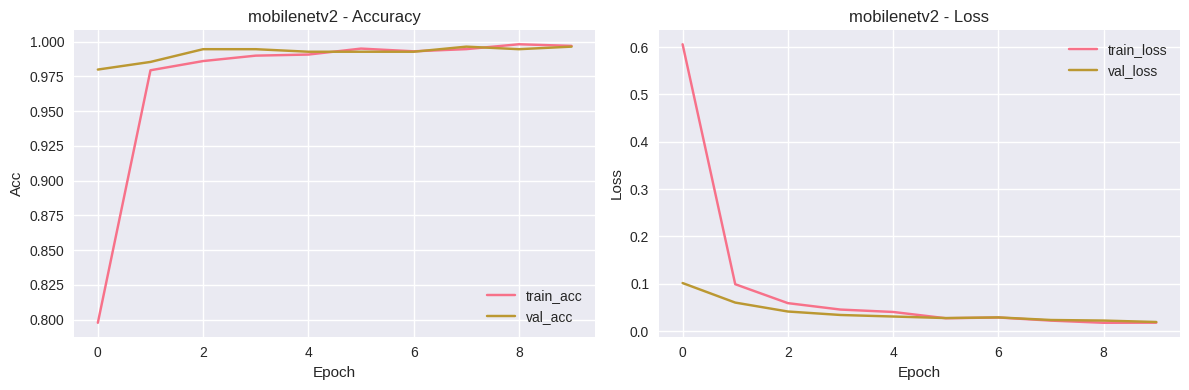

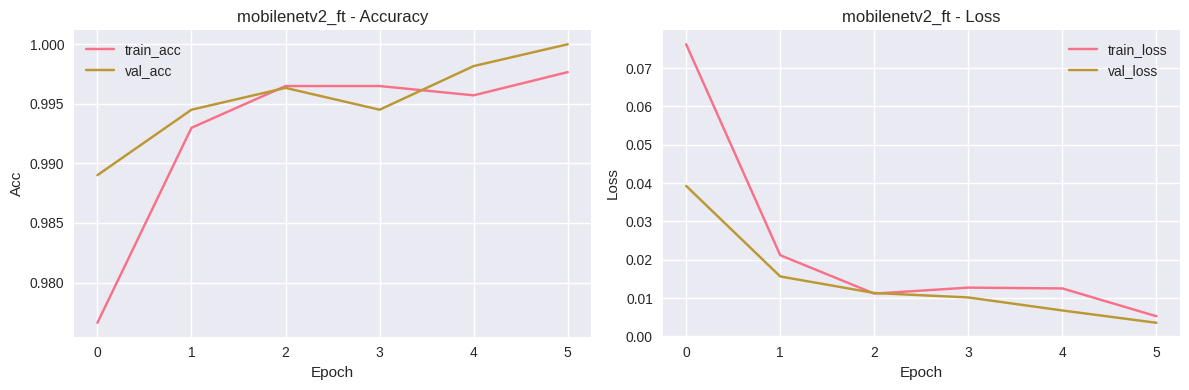


Resultados en TEST (ordenados por accuracy):
                    loss  accuracy
mobilenetv2_ft  0.006332  0.996403
mobilenetv2     0.030115  0.992806
deeper_bn       0.309314  0.913669
baseline        0.257812  0.913669

Mejor modelo: mobilenetv2_ft con accuracy de test = 0.9964

Justificación del mejor modelo:
- mobilenetv2_ft: Ajuste fino del modelo base: adapta mejor las características al dominio de frutas/vegetales.

¡Listo! ✅ Todos los archivos de resultados y checkpoints fueron guardados en: /content/drive/MyDrive/Archivos proyecto final colab


In [16]:
#Fase No.7 Fase 7: Visualización de Resultados y Selección del Mejor Modelo

# Grafico las curvas de entrenamiento.
def plot_history(hist, title):
    acc = hist.history["accuracy"]; val_acc = hist.history["val_accuracy"]
    loss = hist.history["loss"];     val_loss = hist.history["val_loss"]

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(acc, label="train_acc"); plt.plot(val_acc, label="val_acc")
    plt.title(title + " - Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(loss, label="train_loss"); plt.plot(val_loss, label="val_loss")
    plt.title(title + " - Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.tight_layout(); plt.show()

for name, hist in histories.items():
    plot_history(hist, name)

# Comparo y selecciono el mejor modelo.
results_df = pd.DataFrame(test_metrics).T.sort_values("accuracy", ascending=False)
print("\nResultados en TEST (ordenados por accuracy):")
print(results_df)

best_name = results_df.index[0]
best_acc = results_df.loc[best_name, "accuracy"]
print(f"\nMejor modelo: {best_name} con accuracy de test = {best_acc:.4f}")

explicaciones = {
    "baseline": "Arquitectura simple; sirve como línea base para comparar.",
    "deeper_bn": "Más capacidad + BatchNorm/Dropout; suele generalizar mejor que baseline.",
    "mobilenetv2": "Transfer Learning desde ImageNet; muy eficiente con datos limitados.",
    "mobilenetv2_ft": "Ajuste fino del modelo base: adapta mejor las características al dominio de frutas/vegetales."
}
print("\nJustificación del mejor modelo:")
print(f"- {best_name}: {explicaciones.get(best_name, 'Mejor compromiso sesgo-varianza en este conjunto.')}")

# Guardo los resultados en la ruta solicitada.
out_dir = Path("/content/drive/MyDrive/Archivos proyecto final colab")
out_dir.mkdir(parents=True, exist_ok=True) # Me aseguro de que la carpeta exista

results_df.to_csv(out_dir / "test_results.csv", index=True)
with open(out_dir / "class_indices.json","w") as f:
    json.dump(train_flow.class_indices, f, indent=2)

print(f"\n¡Listo! ✅ Todos los archivos de resultados y checkpoints fueron guardados en: {out_dir}")


Cargando el mejor modelo para visualización: /content/checkpoints/best_mobilenetv2_ft.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

Mostrando ejemplos de predicciones (rojo=incorrecto, verde=correcto)...


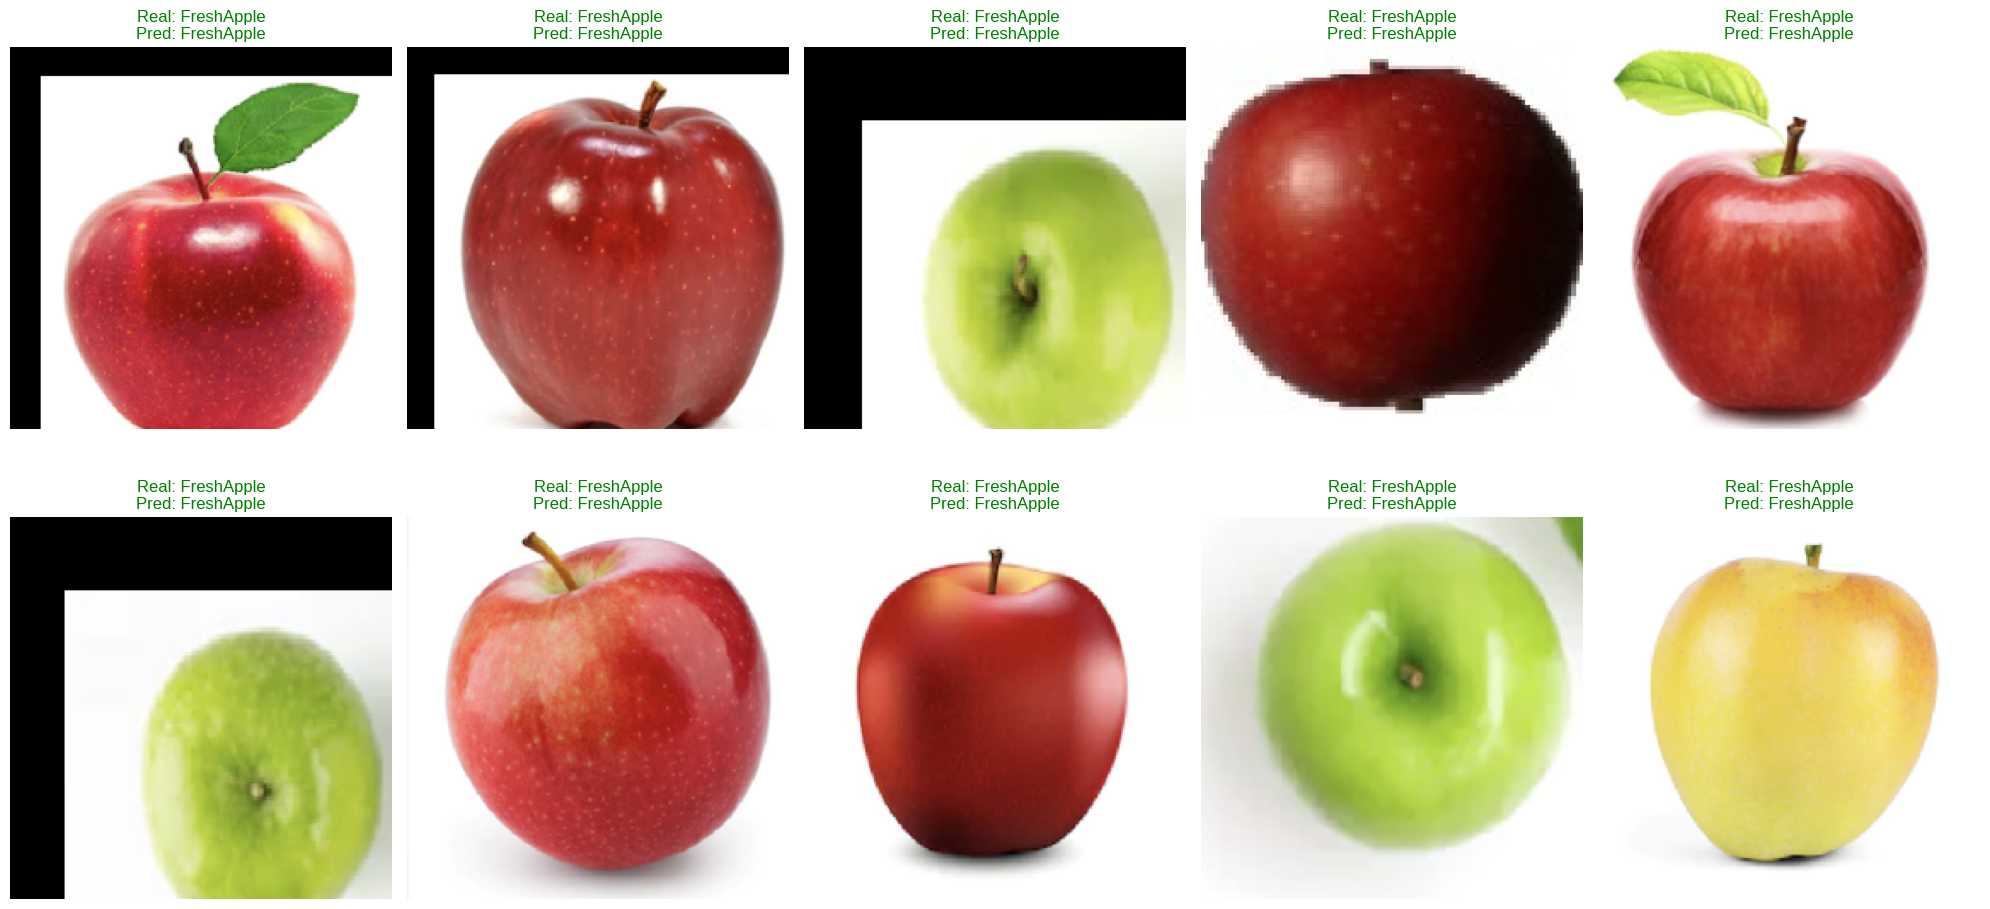

In [19]:
### Fase 8: Análisis Visual del Mejor Modelo

# --- PASO 1: Definir las funciones personalizadas ---
# Necesitamos que las definiciones de las funciones Lambda estén disponibles
# para que Keras pueda entenderlas al cargar el modelo.
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

def mobilenet_preproc_layer(x):
    return mobilenet_preprocess(x * 255.0)

def efficientnet_preproc_layer(x):
    return efficientnet_preprocess(x * 255.0)

# --- PASO 2: Cargar el modelo con los 'custom_objects' ---
best_model_path = ckpt_dir / f"best_{best_name}.keras"
if best_model_path.exists():
    print(f"\nCargando el mejor modelo para visualización: {best_model_path}")

    # ✨ AQUÍ ESTÁ LA CORRECCIÓN ✨
    # Le pasamos un diccionario a Keras para que sepa qué hacer cuando
    # encuentre nuestras funciones personalizadas en el archivo del modelo.
    custom_objects = {
        'mobilenet_preproc_layer': mobilenet_preproc_layer,
        'efficientnet_preproc_layer': efficientnet_preproc_layer
    }
    model = models.load_model(best_model_path, custom_objects=custom_objects)

    # --- El resto del código funciona exactamente igual ---
    # Obtengo un lote de imágenes y etiquetas del conjunto de prueba
    images, labels = next(iter(test_flow))
    true_labels = np.argmax(labels, axis=1)

    # Realizo predicciones
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Visualizo 10 imágenes, sus etiquetas y las predicciones
    print("\nMostrando ejemplos de predicciones (rojo=incorrecto, verde=correcto)...")
    plt.figure(figsize=(20, 10))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])

        real = idx_to_class[true_labels[i]]
        pred = idx_to_class[predicted_labels[i]]

        # Pongo el título en verde si la predicción es correcta, en rojo si no lo es
        title_color = "green" if real == pred else "red"
        plt.title(f"Real: {real}\nPred: {pred}", color=title_color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Cargando el mejor modelo para visualización: /content/checkpoints/best_mobilenetv2_ft.keras
Buscando hasta 5 ejemplos de cada categoría solicitada...

Mostrando galería de predicciones por categoría:


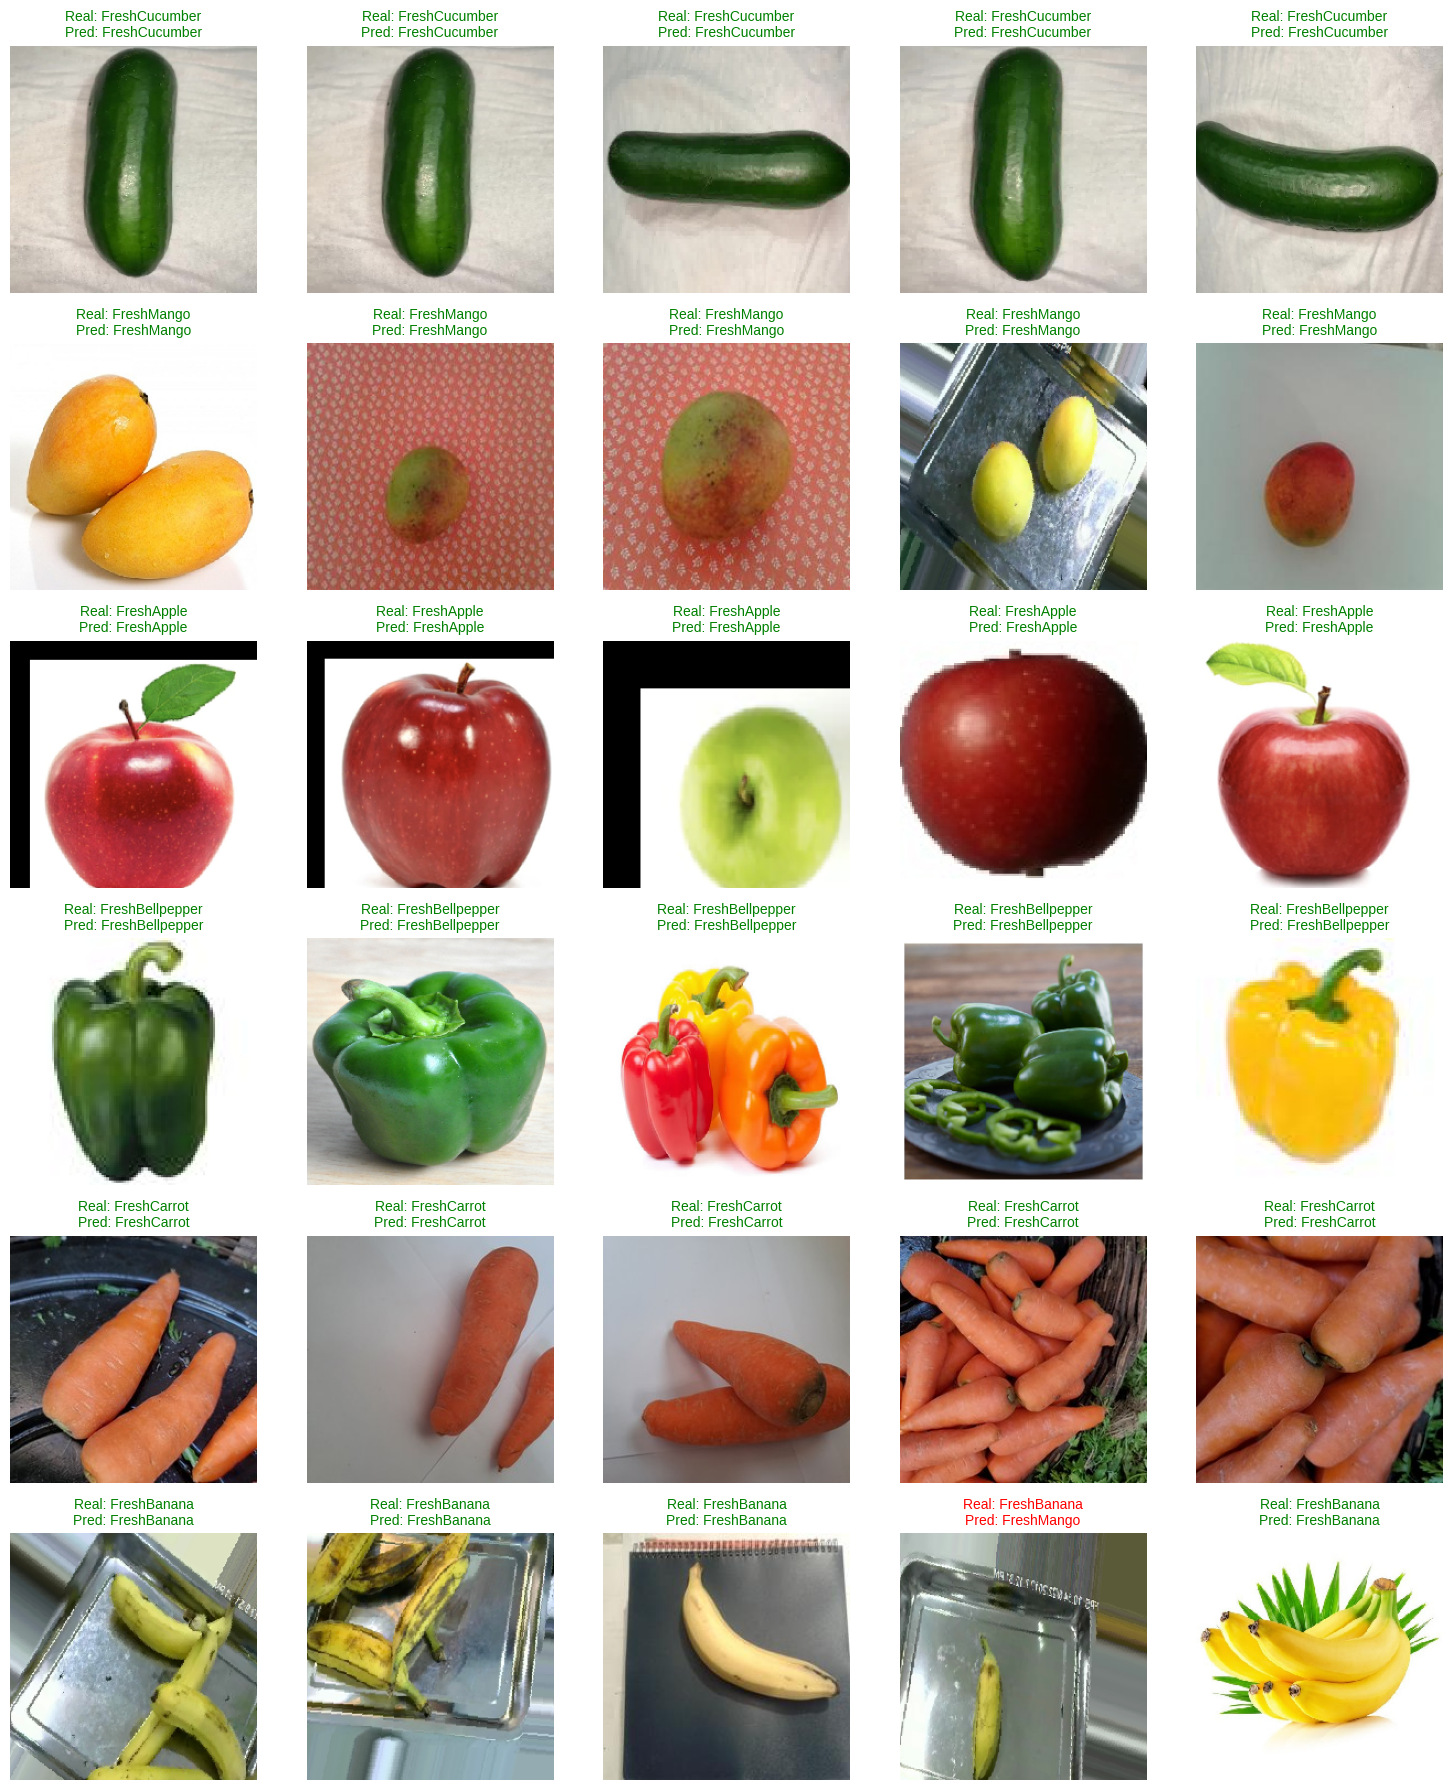

In [23]:
### Fase 8: Galería de Predicciones por Categoría

# --- PASO 1: Definir las funciones personalizadas ---
# Necesitamos estas definiciones para cargar el modelo correctamente.
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

def mobilenet_preproc_layer(x):
    return mobilenet_preprocess(x * 255.0)

def efficientnet_preproc_layer(x):
    return efficientnet_preprocess(x * 255.0)

# --- PASO 2: Cargar el mejor modelo ---
best_model_path = ckpt_dir / f"best_{best_name}.keras"
if best_model_path.exists():
    print(f"\nCargando el mejor modelo para visualización: {best_model_path}")

    custom_objects = {
        'mobilenet_preproc_layer': mobilenet_preproc_layer,
        'efficientnet_preproc_layer': efficientnet_preproc_layer
    }
    model = models.load_model(best_model_path, custom_objects=custom_objects)

    # --- PASO 3: Buscar 5 ejemplos de cada categoría específica ---
    print("Buscando hasta 5 ejemplos de cada categoría solicitada...")

    NUM_EXAMPLES_PER_CLASS = 5

    # ✨ AQUÍ AÑADIMOS 'banana' A LA BÚSQUEDA ✨
    target_keywords = ['cucumber', 'mango', 'apple', 'bellpepper', 'carrot', 'banana']

    # Usamos un diccionario de listas para guardar múltiples ejemplos por clase
    examples_to_show = {keyword: [] for keyword in target_keywords}

    # Para saber cuándo hemos encontrado suficientes ejemplos de todas las clases
    def check_if_complete(examples, keywords, num_required):
        for keyword in keywords:
            if len(examples[keyword]) < num_required:
                return False
        return True

    # Recorremos todo el generador de prueba para encontrar nuestras imágenes
    for images, labels in test_flow:
        # Si ya encontramos todos, detenemos la búsqueda
        if check_if_complete(examples_to_show, target_keywords, NUM_EXAMPLES_PER_CLASS):
            break

        predictions = model.predict(images, verbose=0)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(labels, axis=1)

        # Iteramos sobre las imágenes del lote actual
        for i in range(len(images)):
            true_class_name = idx_to_class[true_labels[i]]

            for keyword in target_keywords:
                # Verificamos si la clase es la que buscamos y si aún necesitamos ejemplos
                if keyword in true_class_name.lower() and len(examples_to_show[keyword]) < NUM_EXAMPLES_PER_CLASS:
                    # Guardamos la información necesaria para la visualización
                    examples_to_show[keyword].append({
                        'image': images[i],
                        'true_label': true_labels[i],
                        'predicted_label': predicted_labels[i]
                    })
                    break # Pasamos a la siguiente imagen

    # --- PASO 4: Visualizar la galería de ejemplos ---
    print("\nMostrando galería de predicciones por categoría:")

    # Creamos una figura con una fila por cada categoría y 5 columnas
    num_categories = len(target_keywords)
    fig, axes = plt.subplots(nrows=num_categories,
                             ncols=NUM_EXAMPLES_PER_CLASS,
                             figsize=(15, 3 * num_categories))

    for row_idx, keyword in enumerate(target_keywords):
        image_data = examples_to_show[keyword]

        # Añadimos el nombre de la categoría como título de la fila
        # Si la figura tiene una sola fila, 'axes' no es un array 2D
        ax_label = axes[row_idx, 0] if num_categories > 1 else axes[0]
        ax_label.set_ylabel(keyword.capitalize(), rotation=0, size='large', labelpad=40, ha='right')

        for col_idx, data in enumerate(image_data):
            # Si la figura tiene una sola fila, 'axes' no es un array 2D
            ax = axes[row_idx, col_idx] if num_categories > 1 else axes[col_idx]
            ax.imshow(data['image'])

            real = idx_to_class[data['true_label']].split()[-1] # Nombre corto
            pred = idx_to_class[data['predicted_label']].split()[-1] # Nombre corto

            title_color = "green" if real == pred else "red"
            ax.set_title(f"Real: {real}\nPred: {pred}", color=title_color, fontsize=10)
            ax.axis("off")

        # Ocultamos los ejes de las celdas vacías si no encontramos 5 ejemplos
        for col_idx in range(len(image_data), NUM_EXAMPLES_PER_CLASS):
            ax = axes[row_idx, col_idx] if num_categories > 1 else axes[col_idx]
            ax.axis("off")

    plt.tight_layout()
    plt.show()